In [1]:
from __future__ import annotations
from typing import *
if TYPE_CHECKING:
    pass
from numpy.lib.function_base import iterable
from src.Kernel import GaussKernel
from src.EllipsoidRenderer import EllipsoidRenderer
from src.GridBuilder import ImageGridBuilder
from read_data import load_position_data
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
data = np.load('data/toastgitter/all_data.npy') # Shape [STEPS, NUM_REL]
p_pos, c_pos = load_position_data('data/toastgitter/LOGFILE_unified_coordinates.txt')
print(data.shape)


(65536, 2013)


In [3]:
NUM_SAMPLES, NUM_RELATIONS = data.shape

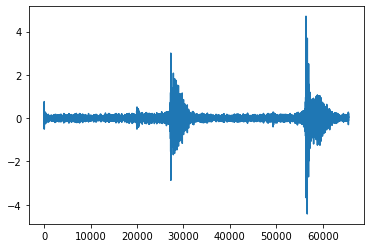

In [4]:
plt.plot(np.mean(data, axis=1))

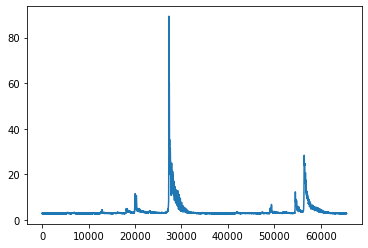

In [5]:
plt.plot(np.std(data, axis=1))

In [68]:
from construct_matrix import MatrixBuilder
mb = MatrixBuilder(
    SPEED_OF_SOUND = 1_484_000.0, # [mm/s]
    SAMPLE_RATE = 100_000_000.0, # [1/s]
    ECHO_START_TIME = 0.0, # [s]

    data_path      = 'data/toastgitter/all_data.npy',
    positions_path = 'data/toastgitter/LOGFILE_unified_coordinates.txt',
    piezo_filter   = lambda pos: np.allclose(pos, np.array([385.0, -110.0, 198.0])),
    cMut_filter    = lambda pos: any(
        np.allclose(pos, np.array([k+311.1, -110.0, 198.0]))
        for k in range(0,61,4)
        for l in range(-5, 7, 5)

    ),
)

u = np.array([40,0,0], dtype=float)
v = np.array([0,0,-20], dtype=float)
o = np.array([320, -110, 10], dtype=float)

res_u = 80
res_v = 40

kernel = GaussKernel(1.0)

In [69]:
mb.plot_positions(u=u, v=v, o=o, res_u=res_u, res_v=res_v, kernel=kernel)

In [70]:

time_start = time.time()
M, lower_sample_idx, upper_sample_idx = mb.build_matrix(u=u, v=v, o=o, res_u=res_u, res_v=res_v, kernel=kernel)
time_stop = time.time()

print(time_stop-time_start)

11.471077680587769


In [71]:
print(lower_sample_idx, upper_sample_idx)

25448 29119


In [72]:
import plotly.express as px
fig = px.imshow(M.reshape([-1,res_u, res_v])[2000], binary_string=True, labels=dict(animation_frame="slice"))
fig.show()

# plt.imshow(M[1000])

In [73]:
time_start = time.time()
Minv= np.linalg.pinv(M)
time_stop = time.time()

print(time_stop-time_start)

38.54909014701843


In [74]:
selected_data = mb.data[lower_sample_idx:upper_sample_idx, mb.selected].flatten(order='F')

time_start = time.time()
x_hat = Minv @ selected_data
time_stop = time.time()
print(time_stop-time_start)

0.05581235885620117


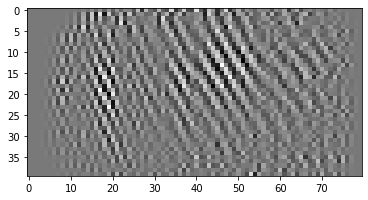

In [75]:
plt.imshow(x_hat.reshape([res_u, res_v])[:,::-1].T, cmap='gray')

In [42]:
import plotly.express as px
fig = px.imshow(Minv[:,50_000:58_000], binary_string=True, labels=dict(animation_frame="slice"))
fig.show()

In [37]:
Minv.shape

(2048, 505056)

## Further steps
- plot data interval in date-mean / std plot
- use gpu via torch
- smear out ellips to reduce data dimensionality
- use numba and calculate matrix directly on gpu
- use matrix chunks to handle larger matricies

In [83]:
# ellipse change
# May be smaller for coarser resulution

import plotly.express as px
fig = px.imshow(M.reshape([-1,res_u, res_v])[1000] - M.reshape([-1,res_u, res_v])[1001], binary_string=True, labels=dict(animation_frame="slice"))
fig.show()
